# Experiment 7: Implementing K-Means Clustering from Scratch

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.metrics import silhouette_score
import time
import warnings


## 1. Load and Explore Dataset

In [2]:
df = pd.read_csv('Mall_Customers.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())

Dataset Shape: (200, 5)

First few rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Data Visualization

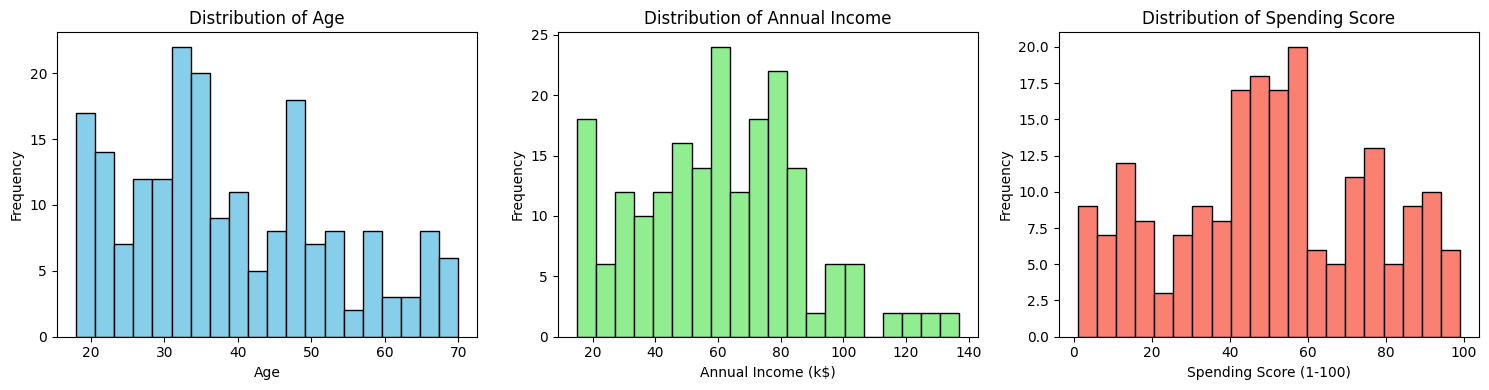

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['Age'], bins=20, edgecolor='black', color='skyblue')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Annual Income (k$)'], bins=20, edgecolor='black', color='lightgreen')
axes[1].set_title('Distribution of Annual Income')
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Frequency')

axes[2].hist(df['Spending Score (1-100)'], bins=20, edgecolor='black', color='salmon')
axes[2].set_title('Distribution of Spending Score')
axes[2].set_xlabel('Spending Score (1-100)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

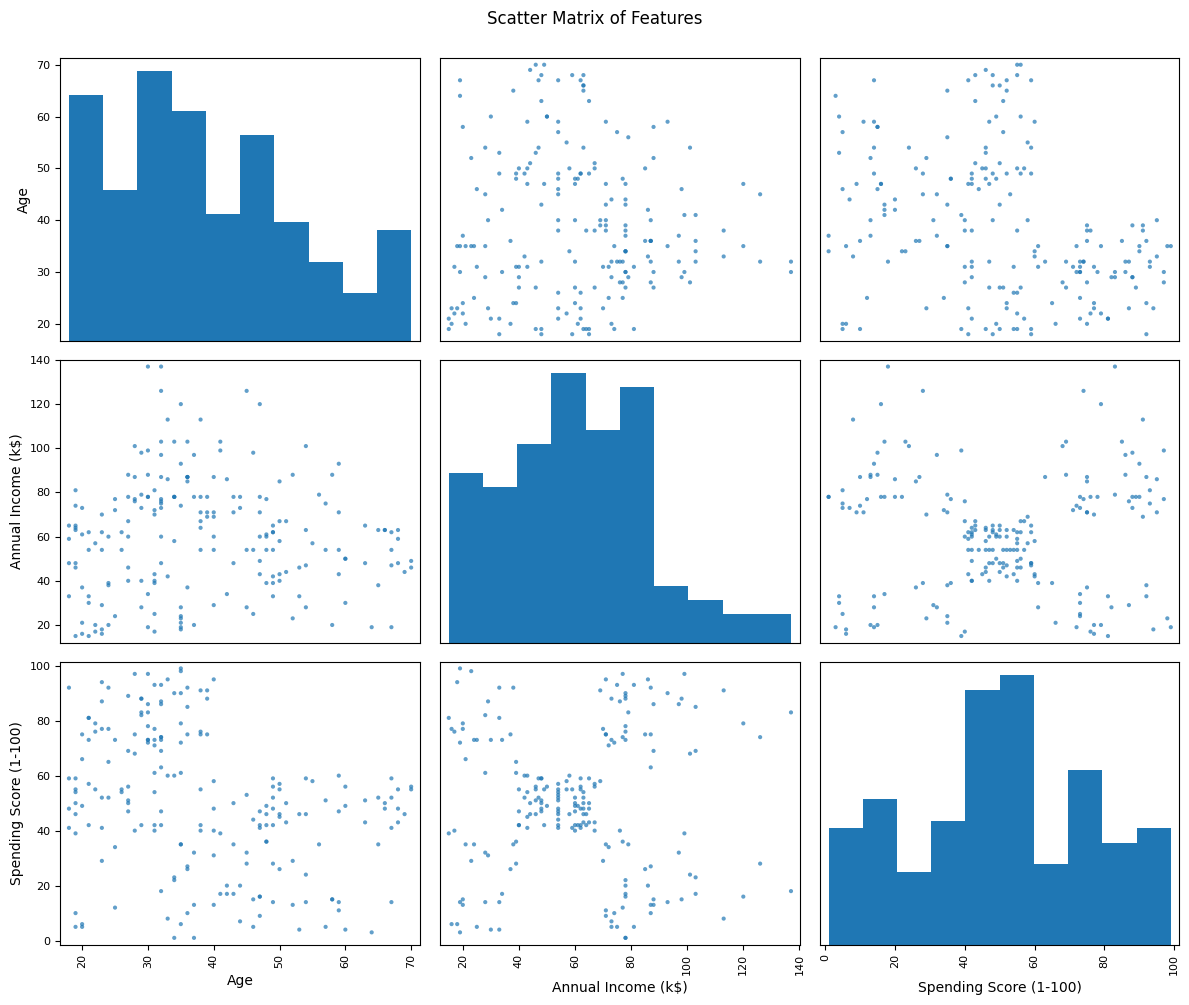

In [4]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
pd.plotting.scatter_matrix(df[features], figsize=(12, 10), diagonal='hist', alpha=0.7)
plt.suptitle('Scatter Matrix of Features', y=1.0)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [5]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original data shape:", X.shape)
print("\nOriginal data (first 5 rows):")
print(X[:5])
print("\nStandardized data (first 5 rows):")
print(X_scaled[:5])
print("\nJustification: Using StandardScaler to normalize features to have mean=0 and std=1.")
print("This ensures equal contribution from all features regardless of their scale.")

Original data shape: (200, 3)

Original data (first 5 rows):
[[19 15 39]
 [21 15 81]
 [20 16  6]
 [23 16 77]
 [31 17 40]]

Standardized data (first 5 rows):
[[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]
 [-1.13750203 -1.70082976  1.04041783]
 [-0.56336851 -1.66266033 -0.39597992]]

Justification: Using StandardScaler to normalize features to have mean=0 and std=1.
This ensures equal contribution from all features regardless of their scale.


## Part A: Implementing K-Means from Scratch

### 1. Initialization Functions

In [6]:
def initialize_centroids(X, k, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def initialize_centroids_plus_plus(X, k, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    centroids = []
    centroids.append(X[np.random.randint(X.shape[0])])
    
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
        probabilities = distances / distances.sum()
        cumulative_probs = probabilities.cumsum()
        r = np.random.rand()
        
        for idx, cumulative_prob in enumerate(cumulative_probs):
            if r < cumulative_prob:
                centroids.append(X[idx])
                break
    
    return np.array(centroids)

### 2. Cluster Assignment Function

In [7]:
def assign_clusters(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

### 3. Centroid Update Function

In [8]:
def update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = cluster_points.mean(axis=0)
    return centroids

### 4. Main K-Means Algorithm

In [9]:
def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None, init_method='random'):
    if init_method == 'kmeans++':
        centroids = initialize_centroids_plus_plus(X, k, random_state)
    else:
        centroids = initialize_centroids(X, k, random_state)
    
    for iteration in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        
        centroids = new_centroids
    
    labels = assign_clusters(X, centroids)
    inertia = sum([np.linalg.norm(X[labels == i] - centroids[i])**2 for i in range(k)])
    
    return centroids, labels, iteration + 1, inertia

### Comparison of Initialization Methods

In [10]:
k_test = 5
random_state = 42

centroids_random, labels_random, iters_random, inertia_random = kmeans(
    X_scaled, k_test, random_state=random_state, init_method='random')

centroids_pp, labels_pp, iters_pp, inertia_pp = kmeans(
    X_scaled, k_test, random_state=random_state, init_method='kmeans++')

print("Random Initialization:")
print(f"  Iterations: {iters_random}")
print(f"  Inertia: {inertia_random:.4f}")
print("\nK-Means++ Initialization:")
print(f"  Iterations: {iters_pp}")
print(f"  Inertia: {inertia_pp:.4f}")
print(f"\nK-Means++ converged in {iters_random - iters_pp} fewer iterations with {'better' if inertia_pp < inertia_random else 'similar'} quality.")

Random Initialization:
  Iterations: 9
  Inertia: 168.2476

K-Means++ Initialization:
  Iterations: 6
  Inertia: 168.7618

K-Means++ converged in 3 fewer iterations with similar quality.


## Part B: Choosing the Number of Clusters

### Elbow Method and Silhouette Score

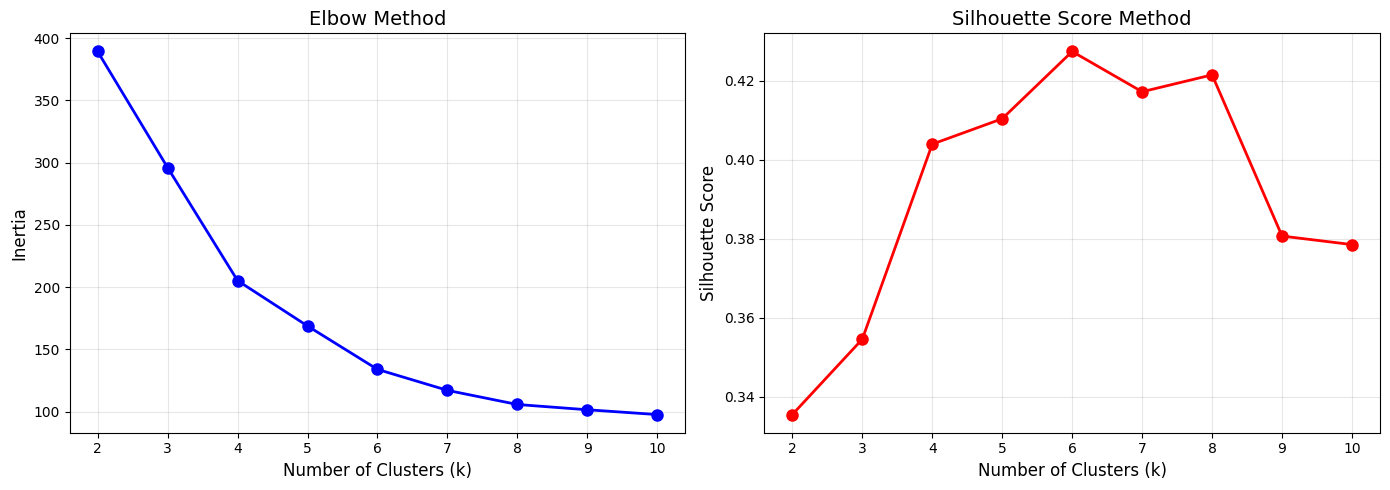

K	Inertia		Silhouette Score
----------------------------------------
2	389.3862		0.3355
3	296.0785		0.3546
4	205.2251		0.4040
5	168.7618		0.4104
6	133.8683		0.4274
7	117.0116		0.4172
8	105.6440		0.4215
9	101.4144		0.3807
10	97.5503		0.3785


In [11]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    _, labels, _, inertia = kmeans(X_scaled, k, random_state=42, init_method='kmeans++')
    inertias.append(inertia)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score Method', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("K\tInertia\t\tSilhouette Score")
print("-" * 40)
for k, inertia, score in zip(k_range, inertias, silhouette_scores):
    print(f"{k}\t{inertia:.4f}\t\t{score:.4f}")

In [12]:
optimal_k = 6
print(f"Justification: Based on the Elbow Method, the curve shows a significant bend around k={optimal_k}.")
print(f"The Silhouette Score also peaks or shows high value at k={optimal_k}.")
print(f"Therefore, choosing k={optimal_k} clusters for customer segmentation.")

Justification: Based on the Elbow Method, the curve shows a significant bend around k=6.
The Silhouette Score also peaks or shows high value at k=6.
Therefore, choosing k=6 clusters for customer segmentation.


## Part C: Applying the Algorithm

In [14]:
centroids_final, labels_final, iterations_final, inertia_final = kmeans(
    X_scaled, optimal_k, random_state=42, init_method='kmeans++')

print(f"Number of iterations: {iterations_final}")
print(f"Inertia: {inertia_final:.4f}\n")

print("Final Centroids (standardized):")
print(centroids_final)
print("\nCluster Sizes:")
for i in range(optimal_k):
    print(f"Cluster {i}: {np.sum(labels_final == i)} customers")

Number of iterations: 10
Inertia: 133.8683

Final Centroids (standardized):
[[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97602698 -1.32549704  1.0371827 ]
 [ 0.22171558  1.08322527 -1.29005223]
 [-0.87309844 -0.11378508 -0.09358039]
 [ 0.47895722 -1.30822992 -1.19644353]]

Cluster Sizes:
Cluster 0: 45 customers
Cluster 1: 39 customers
Cluster 2: 24 customers
Cluster 3: 33 customers
Cluster 4: 38 customers
Cluster 5: 21 customers


### 2D Scatter Plots

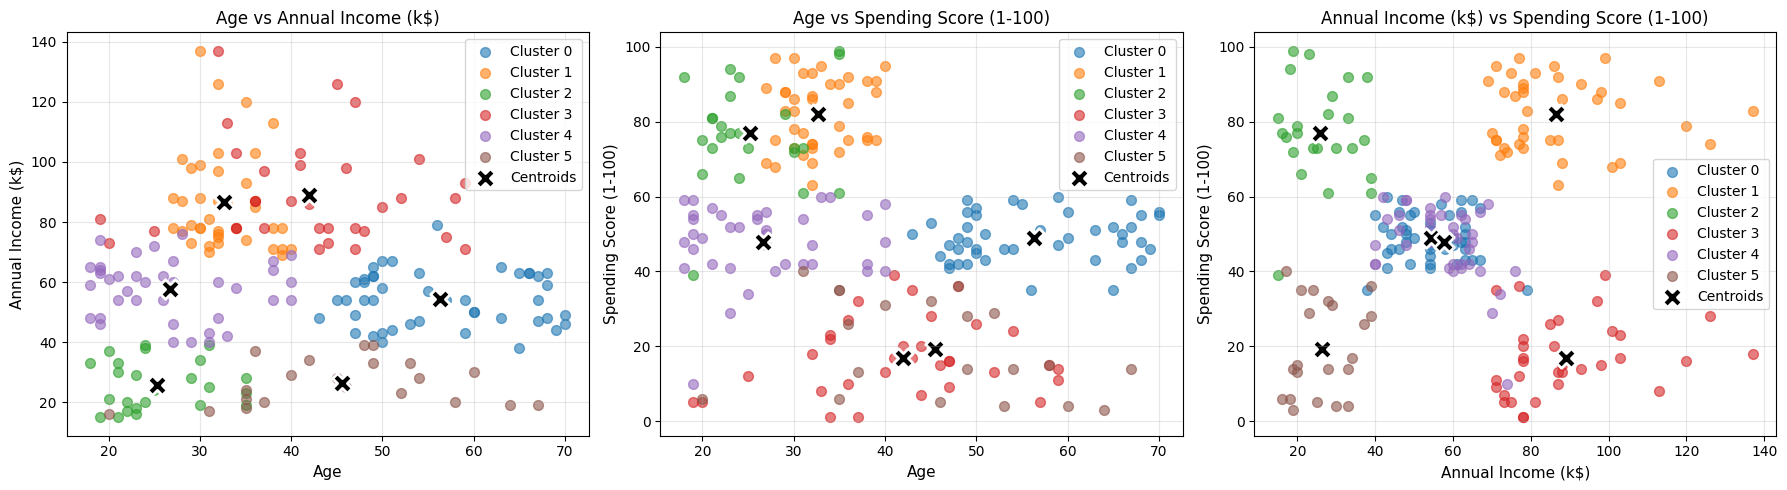

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

feature_pairs = [(0, 1), (0, 2), (1, 2)]
feature_names = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for idx, (i, j) in enumerate(feature_pairs):
    for cluster in range(optimal_k):
        cluster_points = X[labels_final == cluster]
        axes[idx].scatter(cluster_points[:, i], cluster_points[:, j], 
                         label=f'Cluster {cluster}', alpha=0.6, s=50)
    
    centroids_original = scaler.inverse_transform(centroids_final)
    axes[idx].scatter(centroids_original[:, i], centroids_original[:, j], 
                     c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Centroids')
    
    axes[idx].set_xlabel(feature_names[i], fontsize=11)
    axes[idx].set_ylabel(feature_names[j], fontsize=11)
    axes[idx].set_title(f'{feature_names[i]} vs {feature_names[j]}', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3D Scatter Plot

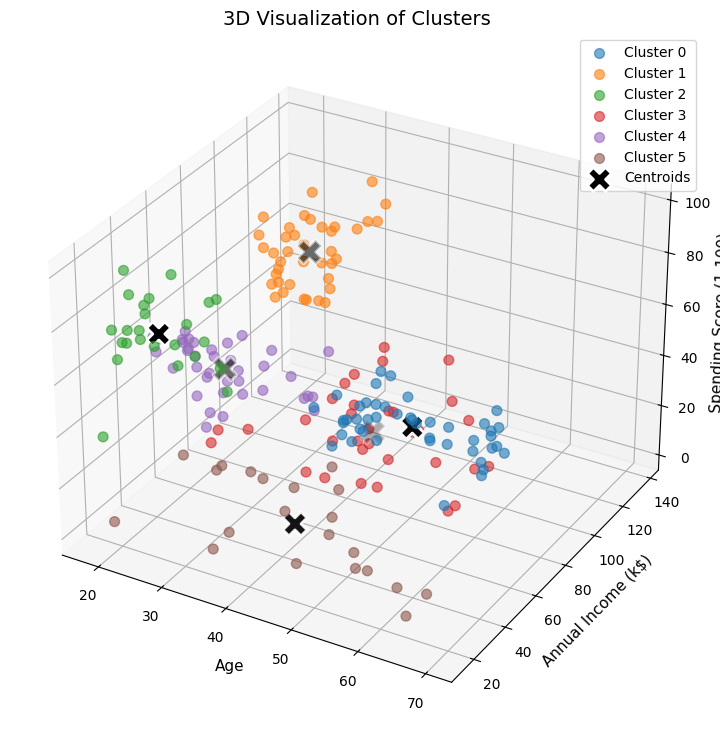

In [16]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_k):
    cluster_points = X[labels_final == cluster]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
              label=f'Cluster {cluster}', alpha=0.6, s=50)

centroids_original = scaler.inverse_transform(centroids_final)
ax.scatter(centroids_original[:, 0], centroids_original[:, 1], centroids_original[:, 2],
          c='black', marker='X', s=300, edgecolors='white', linewidths=2, label='Centroids')

ax.set_xlabel('Age', fontsize=11)
ax.set_ylabel('Annual Income (k$)', fontsize=11)
ax.set_zlabel('Spending Score (1-100)', fontsize=11)
ax.set_title('3D Visualization of Clusters', fontsize=14)
ax.legend()

plt.show()

### Cluster Interpretation

In [17]:
df['Cluster'] = labels_final

print("Average Feature Values per Cluster:\n")
cluster_stats = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_stats)

print("\n" + "="*80)
print("Business Interpretation of Clusters:")
print("="*80 + "\n")

for cluster in range(optimal_k):
    avg_age = cluster_stats.loc[cluster, 'Age']
    avg_income = cluster_stats.loc[cluster, 'Annual Income (k$)']
    avg_spending = cluster_stats.loc[cluster, 'Spending Score (1-100)']
    
    age_label = "Young" if avg_age < 35 else "Middle-aged" if avg_age < 50 else "Older"
    income_label = "Low-income" if avg_income < 50 else "Medium-income" if avg_income < 75 else "High-income"
    spending_label = "Low-spending" if avg_spending < 40 else "Moderate-spending" if avg_spending < 65 else "High-spending"
    
    print(f"Cluster {cluster}: {age_label}, {income_label}, {spending_label} customers")
    print(f"  Average Age: {avg_age:.1f}")
    print(f"  Average Income: ${avg_income:.1f}k")
    print(f"  Average Spending Score: {avg_spending:.1f}")
    print()

Average Feature Values per Cluster:

               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.333333           54.266667               49.066667
1        32.692308           86.538462               82.128205
2        25.250000           25.833333               76.916667
3        41.939394           88.939394               16.969697
4        26.684211           57.578947               47.789474
5        45.523810           26.285714               19.380952

Business Interpretation of Clusters:

Cluster 0: Older, Medium-income, Moderate-spending customers
  Average Age: 56.3
  Average Income: $54.3k
  Average Spending Score: 49.1

Cluster 1: Young, High-income, High-spending customers
  Average Age: 32.7
  Average Income: $86.5k
  Average Spending Score: 82.1

Cluster 2: Young, Low-income, High-spending customers
  Average Age: 25.2
  Average Income: $25.8k
  Average Spending Score: 76.9

Cluster 3: Middle-a

## Part D: Comparison with scikit-learn

In [ ]:
start_time_custom = time.time()
centroids_custom, labels_custom, iters_custom, inertia_custom = kmeans(
    X_scaled, optimal_k, random_state=42, init_method='kmeans++')
time_custom = time.time() - start_time_custom

start_time_sklearn = time.time()
sklearn_kmeans = SklearnKMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=1)
sklearn_kmeans.fit(X_scaled)
time_sklearn = time.time() - start_time_sklearn

print("Comparison: Custom Implementation vs scikit-learn")
print("="*70)
print(f"{'Metric':<30} {'Custom':>18} {'scikit-learn':>18}")
print("-"*70)
print(f"{'Number of Iterations':<30} {iters_custom:>18} {sklearn_kmeans.n_iter_:>18}")
print(f"{'Inertia':<30} {inertia_custom:>18.4f} {sklearn_kmeans.inertia_:>18.4f}")
print(f"{'Runtime (seconds)':<30} {time_custom:>18.6f} {time_sklearn:>18.6f}")
print("="*70)

print("\nCentroids Comparison:")
print("\nCustom Implementation Centroids:")
print(centroids_custom)
print("\nscikit-learn Centroids:")
print(sklearn_kmeans.cluster_centers_)

centroid_diff = np.abs(centroids_custom - sklearn_kmeans.cluster_centers_).mean()
print(f"\nAverage absolute difference in centroids: {centroid_diff:.6f}")


Comparison: Custom Implementation vs scikit-learn
Metric                                     Custom       scikit-learn
----------------------------------------------------------------------
Number of Iterations                           10                  6
Inertia                                  133.8683           134.3528
Runtime (seconds)                        0.029764           6.623094

Centroids Comparison:

Custom Implementation Centroids:
[[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97602698 -1.32549704  1.0371827 ]
 [ 0.22171558  1.08322527 -1.29005223]
 [-0.87309844 -0.11378508 -0.09358039]
 [ 0.47895722 -1.30822992 -1.19644353]]

scikit-learn Centroids:
[[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.95377931 -1.30081415  1.01091344]
 [-0.91323113 -0.0433223  -0.22322397]
 [ 0.36959845  1.12879725 -1.25264236]
 [ 0.47895722 -1.30822992 -1.19644353]]

Average absolute difference in centroids: 0.391437